In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag
import bs4
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from lxml import html
import lxml

## Searching for croissant baking temperatures
- Searches for 'croissant bake temperature' or 'temperature cuisson croissant' were conducted on Google country-specific search sites for the US, UK, and France. The first 100 links were obtained for each country. These links were subsequently scraped to determine if they were a croissant baking recipe, and if so, for their initial baking temperature.
- Baking temperatures were found by looking for sentences that contained the words 'preheat', 'bake', or 'oven' followed by a 3 digit number followed by a temperature indicator. 
- Croissant baking often employs a two-stage approach with a high starting temp followed by a lower finishing temp. The script pulled the first temperature mention, so this is the starting temp.
- For the US graphic, websites were excluded if the first temperature mention was in celsius.
- For the UK and French graphics, websites were excluded if the first temperature mention was in fahrenheit.


## Tools and techniques used in this project
- **Tools**
> - Python, Jupyter Lab, Beautiful Soup, Pandas, Numpy
- **Visualization**
> - Matplotlib
- **Techniques**
> - Web-scraping


In [209]:
import collections.abc
  
def find_value_of_nested_dict_or_list(a, our_key):
    if not isinstance(a, collections.Iterable):
        return False
    if isinstance(a, list):
        for item in a:
            result = find_value_of_nested_dict_or_list(item, our_key)
            if result:
                return result
    if isinstance(a, dict):
        for key in a:
            if key == our_key:
                return a[our_key]
            else:
                result = find_value_of_nested_dict_or_list(a[key], our_key)
                if result:
                    return result
    return False

In [281]:
# url = 'https://www.marthastewart.com/312981/croissants' # 3 1st level is list. target dict is in 2nd position of list
# url = 'https://sallysbakingaddiction.com/homemade-croissants/' # 1. type(data) dict. 
# url = 'https://www.kingarthurbaking.com/recipes/bakers-croissants-recipe' # 1target in dict?
# url = 'https://www.finecooking.com/recipe/classic-croissants' # target in dict
# url = 'https://www.jocooks.com/recipes/homemade-croissants/' # target in dict

url = 'https://www.epicurious.com/recipes/food/views/butter-croissants-103989' #No application/ld+json. Yes to schema.org recipe, but old format
url = 'https://www.weekendbakery.com/posts/classic-french-croissant-recipe/' # No application/ld+json
url = 'https://gourmetier.com/french-croissants/'   # class="entry-content". dict, but target not in dict
url = 'https://topwithcinnamon.com/how-to-make-croissants/'  # dict, but target not in dict
# url = 'https://www.noellecarterfood.com/blog/2019/9/20/better-baking-temperature-croissants-recipe' # dict, but target not in dict

try:       
    r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
    if r.status_code == 406:
        r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html')
#         print(soup.prettify())
        result = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 'post-entry', 'recept', 'recipe-content']})
        print(result)

except Exception as e:
    print('Exception', e)

[<div class="post-entry">
<input class="jpibfi" type="hidden"/><p style="text-align: center;"><a href="http://www.topwithcinnamon.com/wp-content/uploads/2012/12/Croissants-24.jpg"><img alt="Croissants-24" class="aligncenter size-full wp-image-1322" data-jpibfi-post-excerpt="" data-jpibfi-post-title="How to make croissants (a step-by-step guide with .gifs)" data-jpibfi-post-url="https://topwithcinnamon.com/how-to-make-croissants/" data-jpibfi-src="http://www.topwithcinnamon.com/wp-content/uploads/2012/12/Croissants-24.jpg" data-pin-title="How to make croissants (a step-by-step guide with .gifs)" height="1065" sizes="(max-width: 700px) 100vw, 700px" src="http://www.topwithcinnamon.com/wp-content/uploads/2012/12/Croissants-24.jpg" srcset="https://topwithcinnamon.com/wp-content/uploads/2012/12/Croissants-24.jpg 700w, https://topwithcinnamon.com/wp-content/uploads/2012/12/Croissants-24-600x913.jpg 600w, https://topwithcinnamon.com/wp-content/uploads/2012/12/Croissants-24-197x300.jpg 197w, h

In [288]:
class ClassifyWebpage:
    '''Classify webpage'''
    def __init__(self, url, search_pattern_1, search_pattern_2):
        self.url = None
        self.page_type = ''
        self.language = "Not found in page source"
#         self.pastry_name_predict = PastryRecipeWebpage()
        self.recipe_name = ''
        self.cook_time = ''
        self.ingredients = ''
        self.instructions = ''
        try:
            r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
            if r.status_code == 406:
                r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
            if r.status_code == 200:
#                 print(f'Pass {url}')
                self.url = url
                root = lxml.html.fromstring(r.text)
                language_construct = root.xpath("//html/@lang") # this xpath is reliable(in long-term), since this is a standard construct.
                if language_construct:
                    language = language_construct[0].split('-')[0]
                    self.language = language    
        
                soup = BeautifulSoup(r.content, 'html')
                json_data = soup.findAll(type="application/ld+json")
                print(len(json_data))

                # For sites that follow schema.org for 'Recipe'
                for i in range(len(json_data)):
                    data = json.loads(json_data[i].string)
                    self.ingredients = find_value_of_nested_dict_or_list(data,'recipeIngredient')
                    self.instructions = find_value_of_nested_dict_or_list(data,'recipeInstructions')
                    self.recipe_name = find_value_of_nested_dict_or_list(data,'name')
                    self.cook_time = find_value_of_nested_dict_or_list(data,'cookTime')
                
                # For sites that do not follow schema.org for 'Recipe'
                if len(json_data) == 0:
                    self.instructions = soup.find_all('div', attrs={'class': ['body entry-content', 'entry-content', 'post-entry', 'recept', 'recipe-content']}, text=True)

            else:
                print(' ')
#                 print(f'Fail {r.status_code}, {url}')
        except Exception as e:
            pass
            print('Exception', e)
            


In [ ]:
class PastryRecipeWebpage:
    '''A recipe for hand-made croissants'''
    def __init__(self, instructions=None, initial_temp=None, second_temp=None):
        '''Initialize the recipe's attributes'''
        self.instructions = instructions
        self.initial_temp = initial_temp
        if initial_temp and initial_temp > 300:
            self.initial_temp_range = 'US'
        else:
            self.initial_temp_range = 'Europe'
        self.second_temp = second_temp
    

In [208]:
schema_org_dict = {
        "@context": "http://schema.org",
        "@type": "Recipe",
        "mainEntityOfPage": "https://www.marthastewart.com/312981/croissants",
        "name": "Croissants",
        "image": {
          "@type": "ImageObject",
          "url": "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fassets.marthastewart.com%2Fstyles%2Fwmax-300%2Fd24%2Fcroissant-0506-mla101839%2Fcroissant-0506-mla101839_vert.jpg%3Fitok%3DKKXZXmd-",
          "width": 300,
          "height": 375
        },
        "datePublished": "2010-11-24T07:44:05.000Z",
        "description": "Follow our step-by-step recipe to make a classic baked good worthy of a French pastry shop.",
        "prepTime": None,
        "cookTime": None,
        "totalTime": None,
        "recipeYield": "Makes about 20 croissants",
        "recipeIngredient": [
          "1/2 ounce active dry yeast",
          "1/4 cup warm water (110 degrees to 115 degrees)",
          "1/4 cup sugar",
          "2 tablespoons unsalted butter, melted, plus more for bowl",
          "2 1/3 cups (12 ounces) bread flour",
          "3 cups plus 3 tablespoons (1 pound) all-purpose flour, plus more for working",
          "1 tablespoon salt",
          "2 cups warm whole milk (100 degrees to 115 degrees)",
          "1/4 cups all-purpose flour",
          "2 cups (4 sticks) unsalted butter, slightly softened",
          "1 large egg, lightly beaten"
        ],
        "recipeInstructions": [
          {
            "@type": "HowToStep",
            "text": "Make the dough: Stir yeast, water, and 1 teaspoon sugar in a bowl. Let stand until foamy, about 5 minutes. Butter a large bowl; set aside. Put bread flour, all-purpose flour, remaining 3 tablespoons plus 2 teaspoons sugar, and the salt into the bowl of an electric mixer fitted with the dough hook; mix on low speed until combined. Add yeast mixture, milk, and butter; mix until dough just comes together."
          },
          {
            "@type": "HowToStep",
            "text": "Knead dough: Scrape dough out onto a lightly floured work surface. Using lightly floured hands, knead until smooth, about 3 minutes. Transfer to buttered bowl, turning to coat."
          },
          {
            "@type": "HowToStep",
            "text": "Let dough rise: Cover dough with plastic wrap; transfer to the refrigerator. Let rise until doubled in bulk, about 2 hours (dough should not spring back when you press it with your finger)."
          },
          {
            "@type": "HowToStep",
            "text": "Make the butter package: About 45 minutes after the dough begins rising, put flour and butter into the clean bowl of an electric mixer fitted with the paddle attachment. Mix on medium speeduntil well combined, 3 to 4 minutes. Scrape butter mixture out onto a piece of parchment paper; shape into a rectangle. Top with parchment, and roll out to an 8-by-10-inch rectangle. Transfer to a baking sheet, and refrigerate 30 minutes."
          },
          {
            "@type": "HowToStep",
            "text": "Roll out dough: Turn out dough onto a lightly floured work surface; shape into a rectangle. Roll out to a 10 1/2-by-16-inch rectangle, about 1/2 inch thick, with short side facing you."
          },
          {
            "@type": "HowToStep",
            "text": "Place butter package on dough: The butter package should be cool but pliable; your finger should leave an indentation but the butter should still hold its shape. If too soft, continue to refrigerate; if too firm, let stand at room temperature briefly. Place horizontally on bottom half of dough; remove parchment. Fold top half of dough over butter package, and pinch edges of dough to seal."
          },
          {
            "@type": "HowToStep",
            "text": "Roll in butter: Turn dough so that a short side is facing you and the seam is on the right. Roll out to a 10-by-20-inch rectangle, about 1/2 inch thick (keep the corners as square as possible)."
          },
          {
            "@type": "HowToStep",
            "text": "Fold dough into thirds: Remove any excess flour with a pastry brush. Starting at the far end, fold rectangle in thirds as you would a business letter (this completes the first of 3 \"turns\")."
          },
          {
            "@type": "HowToStep",
            "text": "Mark dough: Mark the dough with your knuckle (later, this will help you remember how many turns have been completed). Wrap dough in plastic, and refrigerate 1 hour."
          },
          {
            "@type": "HowToStep",
            "text": "Repeat process: Remove from refrigerator, and press the dough; it should be pliable but have some resistance. If too soft, return to refrigerator; if too firm, let stand at room temperature, 5 minutes. Repeat the preceding three steps to complete two more turns (make 2 marks for the second turn and 3 marks for the third turn); always start with a short side facing you and the seam on the right, rolling lengthwise before crosswise. After the second turn, wrap dough in plastic, and refrigerate 1 hour. After the third and final turn, wrap dough in plastic, and refrigerate 8 hours (or overnight)."
          },
          {
            "@type": "HowToStep",
            "text": "Roll out and chill dough: Turn out dough onto a lightly floured work surface, and roll out to a 30-by-16-inch rectangle. If dough becomes unmanageable, cut in half crosswise, and roll out two 15-by-16-inch rectangles (refrigerate 1 piece as you work with the other). Chill in freezer 15 minutes. Remove dough, and remeasure: It should match original dimensions; if not, roll out again. If dough becomes too warm or elastic, chill in freezer, 15 minutes."
          },
          {
            "@type": "HowToStep",
            "text": "Cut dough: Cut dough into two 30-by-8-inch rectangles (or four 15-by-8-inch rectangles). Stack rectangles, lining up edges (if you have four smaller rectangles, make two stacks)."
          },
          {
            "@type": "HowToStep",
            "text": "Trim dough and cut into triangles: Using a pastry or pizza wheel and cutting at a 20-degree angle, trim a small wedge from one short side to create an angled side. Cut dough into triangles, each with a 4 1/2-inch base. You should have about 20 total."
          },
          {
            "@type": "HowToStep",
            "text": "Cut slits: Cut a 1-inch slit in the middle of the base of each triangle. Separate the stacks, transferring half the triangles to a parchment-lined baking sheet; cover, and refrigerate."
          },
          {
            "@type": "HowToStep",
            "text": "Begin shaping croissants: Working with one triangle at a time and keeping remaining triangles covered with a clean kitchen towel, hold the two corners of the base, and stretch to lengthen it slightly. Grasp inner corners formed by the slit in the base, and lift and stretch them toward the outer sides of the triangle; press to seal."
          },
          {
            "@type": "HowToStep",
            "text": "Roll croissants: Using your fingertips, roll the base of the triangle up and away from you, stretching the dough slightly outward as you roll to elongate the point (when finished, the point should be tucked under the croissant)."
          },
          {
            "@type": "HowToStep",
            "text": "Finish shaping croissants: Bend the two ends toward you to form a crescent shape (the ends should almost touch). Transfer to parchment-lined baking sheets, spacing croissants 2 inches apart. Repeat with remaining triangles. Cover loosely with plastic wrap, and let stand in a warm place until croissants have doubled in bulk and are very soft, 1 1/2 hours to 2 1/4 hours, depending on the temperature of room."
          },
          {
            "@type": "HowToStep",
            "text": "Brush with egg: Preheat oven to 400 degrees, with racks in upper and lower thirds. Brush tops of croissants with egg. Bake, rotating sheets halfway through, until croissants are puffed and golden brown, 20 to 25 minutes. Let cool slightly on sheets on wire racks. Serve warm or at room temperature."
          }
        ],
        "recipeCategory": [
          "Food &amp; Cooking",
          "Breakfast &amp; Brunch Recipes"
        ],
        "recipeCuisine": [],
        "author": {
          "@type": "Organization",
          "name": "Martha Stewart"
        }
    }

## Step one
### Get links for the target search term

In [12]:
#  The easiest way to change the search is to type a search in google then copy and paste the address.
#  Convert to an f string, find start=0 in the string and change it to start={bundle}.

# us_google_url=f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969"
# fr_google_url=f"https://www.google.fr/search?q=temp%C3%A9rature+cuisson+croissant&ei=0PEzX4C2PMXk-gTv_ImwCA&start={bundle}&sa=N&ved=2ahUKEwiA3szk5ZXrAhVFsp4KHW9-AoYQ8NMDegQIDRBC&biw=1848&bih=942"
# uk_google_url=f"https://www.google.co.uk/search?q=croissant+temperature&ei=OPQzX8T0KMj4-gSnn5moBw&start={bundle}&sa=N&ved=2ahUKEwjE8JaK6JXrAhVIvJ4KHadPBnUQ8NMDegQIDhA_&biw=1848&bih=942"

target_links = 140
page_bundles = list(range(0,target_links,10))
links=[]
for bundle in page_bundles:
    links_list = get_links_from_google_search(f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969")
    for link in links_list:
        links.append(link)

### Write results to file from Google search function

In [10]:
# Uncomment country to write results

# uk_croissant_links = pd.DataFrame(links)
# uk_croissant_links.to_csv('data/uk-croissant-links.txt')

# us_croissant_links = pd.DataFrame(links)
# us_croissant_links.to_csv('data/us-croissant-links.txt')

# fr_croissant_links = pd.DataFrame(links)
# fr_croissant_links.to_csv('data/fr-croissant-links.txt')

## Step two
### Read in links file and initiate web search

In [262]:
# url_list = pd.read_csv('data/uk-croissant-links.txt',header=None)
url_list = pd.read_csv('data/us-croissant-links.txt',header=None)
# url_list = pd.read_csv('data/fr-croissant-links.txt',header=None)

In [289]:
# search_string_1 = r'([A-Z][^.]*(?:four|cuisson|cuir|chauff)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #French regex
# search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:ºC| ºC|°C| °C|C| C)[^.]*(?:[.]|[\s]))' #UK regex
search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #US regex
search_string_2 = r'(\d{3})'

good_url, instr, init_temp, init_temp_range = [], [], [], []
# range(len(url_list)):
tally = 0
recipe_dict = []
[recipe_dict.append(ClassifyWebpage(url_list[1][i], search_string_1, search_string_2)) for i in range(20)]

for page in recipe_dict:
    if page.url:
            print(page.url)
#             print(page.recipe_name)
            print(page.instructions)
            tally += 1
    else:
        print("NO DATA")
print(f'TOTAL PAGES READ: {tally}')

#     if page.pastry_recipe.instructions and page.pastry_recipe.initial_temp_range == 'US':
#         good_url.append(page.url)
#         instr.append(page.pastry_recipe.instructions)
#         init_temp.append(page.pastry_recipe.initial_temp)
#         init_temp_range.append(page.pastry_recipe.initial_temp_range)

# df = pd.DataFrame([good_url, instr, init_temp]).T

1
1
0
0
2
1
2
1
1
4
1
0
1
1
1
1
1
3
 
Exception ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
https://sallysbakingaddiction.com/homemade-croissants/
[{'@type': 'HowToStep', 'text': 'Watch the video above and use the step-by-step photos before you begin. Read the recipe before beginning. Make room in the refrigerator for a baking sheet. In step 6 and again in step 13, you will need room for 2 baking sheets.', 'name': 'Preliminary notes', 'url': 'https://sallysbakingaddiction.com/homemade-croissants/#instruction-step-1'}, {'@type': 'HowToStep', 'text': 'Cut the butter in four 1-Tablespoon pieces and place in the bowl of an electric stand mixer fitted with the dough hook attachment (or you can use a handheld mixer or no mixer, but a stand mixer is ideal). Add the flour, sugar, salt, and yeast. Turn the mixer on low-medium speed to gently combine the ingredients for 1 minute. With the mixer running, slowly pour in the milk. Once all of the mil

In [130]:
df.iloc[:,2]

0     250
1     240
2     220
3     200
4     210
5     200
6     240
7     220
8     170
9     200
10    180
11    180
12    170
13    190
14    160
15    200
16    190
17    150
18    270
19    180
20    210
21    260
22    200
23    220
24    190
25    180
26    180
27    200
28    230
29    220
30    170
31    200
32    180
33    170
34    160
35    180
36    190
37    220
38    220
39    170
40    170
41    180
42    175
43    180
44    100
45    220
46    175
47    180
48    180
49    190
50    170
51    220
52    100
53    200
54    180
Name: 2, dtype: object

### Write search results to file

In [131]:
# Uncomment country to write results

# us_df = pd.DataFrame(df)
# us_df.to_csv('data/us_results.csv')

# uk_df = pd.DataFrame(df)
# uk_df.to_csv('data/uk_results.csv')

# fr_df = pd.DataFrame(df)
# fr_df.to_csv('data/fr_results.csv')

## Results and visualizations
- Of the 100 links obtained from the Google search by country, 35-40 usable temperatures were obtained for the US distribution and for the French distribution.
- Only 10 usable temperatures were obtained for the UK distribution. This is likely due to many recipes of US origin appearing in the google.uk search and being filtered out due to the restriction that temps needed to be expressed primarily in celsius.
- Mean temperatures are similar for all three countries.
- The distributions are different for the countries with the US having a narrower distribution of initial baking temperature and the French distribution being wider.

In [132]:
data_us = pd.read_csv('data/us_results.csv',header=None)
data_uk = pd.read_csv('data/uk_results.csv',header=None)
data_fr = pd.read_csv('data/fr_results.csv',header=None)

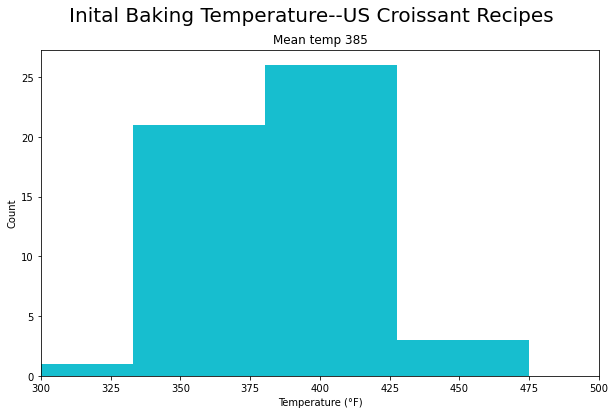

In [139]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(data_us.iloc[:,3], color='tab:cyan')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--US Croissant Recipes', size =20)
ax.set_title(f'Mean temp {data_us.iloc[:,3].mean():.0f}')
plt.savefig('img/us-croissant-baketemp-distribution.png')


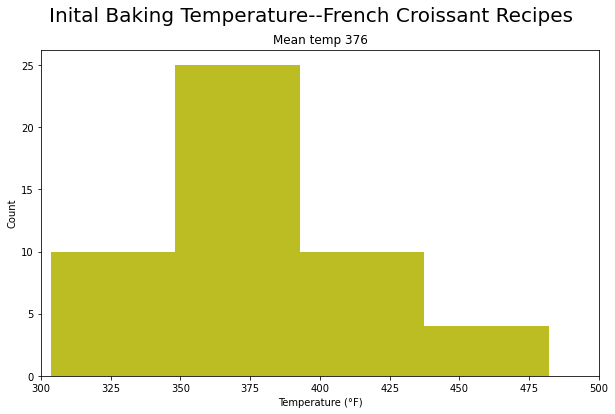

In [140]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_fr.iloc[:,3]*9/5+32), color='tab:olive')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--French Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_fr.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/fr-croissant-baketemp-distribution.png')
# (data_uk.iloc[:,2]*9/5+32).hist()
# (data_fr.iloc[:,2]*9/5+32).hist()


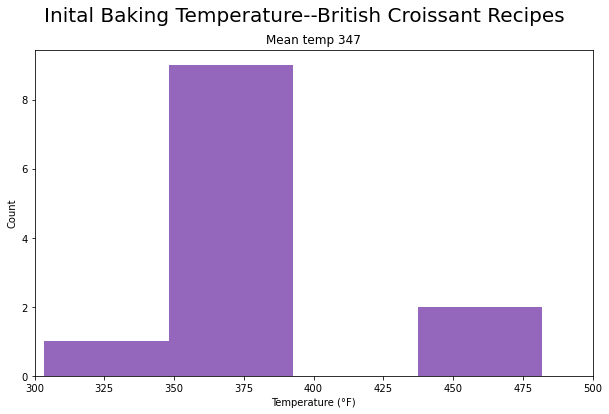

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_uk.iloc[:,3]*9/5+32), color='tab:purple')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--British Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_uk.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/uk-croissant-baketemp-distribution.png')


## Future Research
- Seek to obtain more usable temperatures by grabbing more links from Google and/or by refining the sifting of the websites to obtain a better yield.
- Consider how best to compare the distributions.
- Explore other parameters of croissant preparation and baking.
- Explore the comments for the various websites to determine if people in the respective countries interact differently with recipe authors.